In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import csv
import tweepy # https://github.com/tweepy/tweepy
import numpy as np
import pandas as pd
import configparser

In [ ]:
Handler = 'elonmusk'
path = 'drive/MyDrive/Colab Notebooks/COE494_Project'

In [ ]:
def authenticate(path = 'drive/MyDrive/Colab Notebooks/COE494_Project/'):
  # read config
  config = configparser.ConfigParser()
  config.read(path + 'config.ini')

  api_key = str(config['twitter']['api_key'])
  api_key_secret = str(config['twitter']['api_key_secret'])

  access_token = str(config['twitter']['access_token'])
  access_token_secret = str(config['twitter']['access_token_secret'])

  # authenticate
  auth = tweepy.OAuthHandler(api_key, api_key_secret)
  auth.set_access_token(access_token, access_token_secret)

  return tweepy.API(auth, wait_on_rate_limit = True)

In [ ]:
api = authenticate()

In [ ]:
# Tweet text pre-processing
def clean_tweet(tweet):
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
    if type(tweet) == float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
    temp = [w for w in temp if not w in stopwords]
    temp = " ".join(word for word in temp)
    return temp

In [ ]:
def get_all_tweets(handler):
    # Twitter only allows access to a users most recent 3240 tweets with this method
    print(f'Grabbing @{handler}\'s Tweets')
    #initialize a list to hold all the tweepy Tweets
    all_tweets = []  
    
    # make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = handler, count = 200, include_rts = False, tweet_mode = 'extended')
    
    # save most recent tweets
    all_tweets.extend(new_tweets)
    
    # save the id of the oldest tweet less one
    oldest = all_tweets[-1].id - 1
    
    # keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:        
        # all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = handler, count = 200, max_id = oldest, include_rts = False, tweet_mode = 'extended')
        # save most recent tweets
        all_tweets.extend(new_tweets)        
        # update the id of the oldest tweet less one
        oldest = all_tweets[-1].id - 1
        
    print(f"{len(all_tweets)} tweets downloaded...")    
    # transform the tweepy tweets into a 2D array that will populate the csv 
    out_tweets = [[tweet.id_str, tweet.created_at, tweet.full_text] for tweet in all_tweets]
    df = pd.DataFrame (out_tweets, columns = ["id", "time", "tweet"])
    df.to_csv(path + '/data/' + handler+'.csv')
    return df

In [ ]:
# tweets = get_all_tweets(Handler)
tweets = pd.read_csv(path + "/data/" + Handler + ".csv")
cleaned_tweets = pd.DataFrame([clean_tweet(tweet) for tweet in tweets.tweet], columns = ['tweet'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,4,9,14,16,17,19,22,24,25,26,31,33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Removing null and empty rows 
cleaned_tweets.tweet.replace('', np.nan, inplace=True)
cleaned_tweets.dropna(inplace = True)
cleaned_tweets

,tweet
0,please ignore prior tweets as that was someone...
1,so true
2,if you ever wanted know real truth about moon ...
3,walked around neighborhood recently rebuilt wi...
4,it was xmas so we brought presents kids at orp...
...,...
34870,reminds me when i hex edited ultima v get out ...
34871,yay switzerland
34872,there is no way be touch with voters when you ...
34874,let s make roaring 20 s happen


In [ ]:
from fastai.text import *

In [ ]:
data = TextList.from_df(cleaned_tweets, cols='tweet').split_by_rand_pct(0.1).label_for_lm().databunch(bs = 48)

data.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


idx,text
0,justice i support them would recommend others do too xxbos just returned trip haiti covered lot ground saw many tough situations they need lot help xxbos single character tweets are ulitmate extension twitmeme xxbos i xxbos russians are having some challenges with their rockets too many engineers that designed them have retired xxbos we had long interesting conversation many subjects he has exciting ideas extending his creative talents beyond music
1,xxbos interesting piece xxbos auto dealer sterling mccall makes case tesla direct sales texas xxbos congrats supersonic test flight xxbos first test falcon 9 r reusable ignition system not long now before hold down fire xxbos am good public transit la but pace that construction makes 405 look fast xxbos this argument is bit silly city will not grow infinite size just because there is nt traffic xxbos cool thanks
2,graphite story beyond ridiculous xxbos yes i m confident that tesla will do something with them xxbos well now that satoshi nakamoto has been discovered i guess it is case closed xxbos just discovered great tesla ad made by 2 recent college grads i love it xxbos new jersey auto dealers subverting democratic process try block tesla sales xxbos interesting physicist proposes new type computing at sxsw check out orbital
3,looks good xxbos t minus five minutes flame xxbos flight computer aborted rocket hold down firing anomaly addressed cycling systems countdown xxbos am excited announce that solarcity has filed ipo mission is bring affordable solar power people xxbos just confirmed with that may 7th is go launch falcon 9 amp dragon space station xxbos am pushing launch back approx week do more testing dragon docking code new date pending coordination
4,yes xxbos live video feed launch at xxbos about hour away launch i d like thank taking chance we ve given it our all xxbos cool xxbos i agree will be restored shortly xxbos it was fixed this weekend so he should try test again xxbos writer this article had problem with his 12v battery so main pack was constantly charging it xxbos german govt reviews tesla model s fires


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,7.126532,6.450367,0.091644,00:16
1,5.992862,5.439669,0.169826,00:16
2,5.045690,4.635789,0.247527,00:16
3,4.232103,4.035997,0.322505,00:16
4,3.621923,3.656027,0.383425,00:16
5,3.235579,3.394858,0.426419,00:16
6,2.955895,3.226457,0.458974,00:16
7,2.754827,3.106467,0.480975,00:16
8,2.601648,3.009402,0.499336,00:16
9,2.464247,2.931408,0.515545,00:16


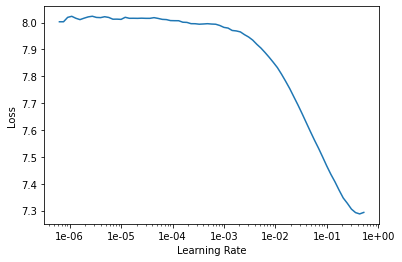

In [ ]:
# Create deep learning model
learn = language_model_learner(data, AWD_LSTM, drop_mult = 0.3, model_dir = '/tmp/work')

# select the appropriate learning rate
learn.lr_find()

# we typically find the point where the slope is steepest
learn.recorder.plot(skip_end = 15)

# Fit the model based on selected learning rate
learn.fit_one_cycle(15, 1e-2, moms = (0.8, 0.7))

In [ ]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(9112, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(9112, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=9112, bias=True)
    (output_dp): RNNDropout()
  )
)

In [ ]:
# Predict Tweets starting from the given words 
# Generates random length from the training set

## Random Number of words and seed word may be generated, however we are choosing
## constant values for comparison sake
### N_WORDS = 0
### while N_WORDS < 10:
###   N_WORDS = len(cleaned_tweets.sample().tweet.item())

### seed = cleaned_tweets.sample().tweet.item().split()[0]

seed = 'roadster'
N_WORDS = 10
print(learn.predict(seed, N_WORDS, temperature = 0.75))

roadster upgrade details xxbos good point xxbos amp xxbos yes when


In [ ]:
seed = 'finally'
N_WORDS = 10
print(learn.predict(seed, N_WORDS, temperature = 0.75))

finally xxbos xxbos important problem with all weather 300 km h
